In [2]:
%matplotlib inline
import math
import gc
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [3]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
train_csv = pd.read_csv(f'dataset/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
test_csv = pd.read_csv(f'dataset/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
submission_csv = pd.read_csv(f'dataset/sample_submission.csv', index_col='id')
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}
structures_csv = pd.read_csv(f'dataset/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')

C:\Users\avglinsky\Miniconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Extend the dataset

In [4]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))
    
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)
            
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [5]:
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
df = take_n_atoms(full, 7).fillna(0)
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)

In [6]:
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 20,
    'reg_alpha': 0.2,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [7]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=2000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=100)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.430851	valid_1's l1: 0.535862
[200]	training's l1: 0.355222	valid_1's l1: 0.485171
[300]	training's l1: 0.306765	valid_1's l1: 0.456667
[400]	training's l1: 0.272551	valid_1's l1: 0.441111
[500]	training's l1: 0.246132	valid_1's l1: 0.429898
[600]	training's l1: 0.22365	valid_1's l1: 0.420405
[700]	training's l1: 0.20523	valid_1's l1: 0.413958
[800]	training's l1: 0.189165	valid_1's l1: 0.408729
[900]	training's l1: 0.174973	valid_1's l1: 0.404153
[1000]	training's l1: 0.162605	valid_1's l1: 0.400103
[1100]	training's l1: 0.150907	valid_1's l1: 0.397077
[1200]	training's l1: 0.140981	valid_1's l1: 0.394478
[1300]	training's l1: 0.132393	valid_1's l1: 0.391983
[1400]	training's l1: 0.124502	valid_1's l1: 0.390582
[1500]	training's l1: 0.117231	valid_1's l1: 0.388712
[1600]	training's l1: 0.110336	valid_1's l1: 0.387463
[1700]	training's l1: 0.10414	valid_1's l1: 0.385929
[1800]	training's l1: 0.0985554	

-0.9587955942680777

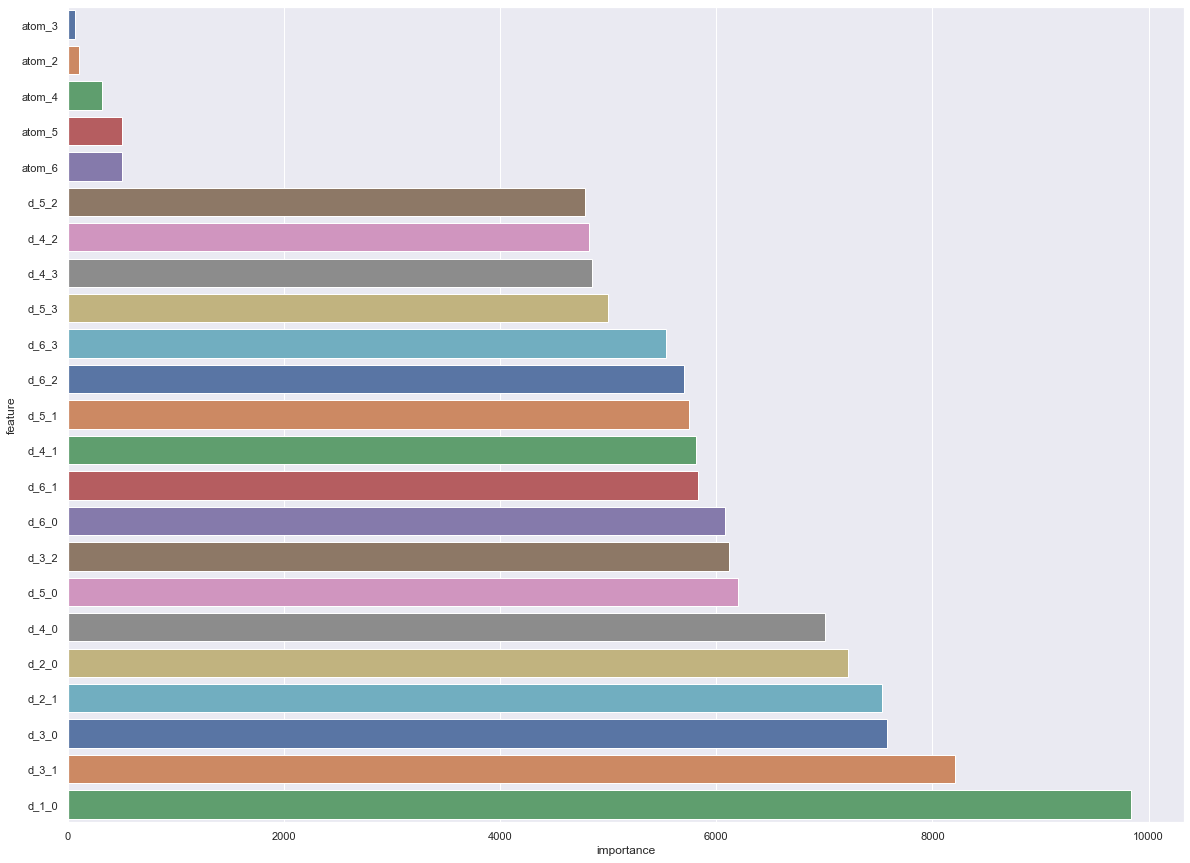

In [8]:
sns.set(rc={'figure.figsize':(20,15)})
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns_plot = sns.barplot(x="importance", y="feature", palette="deep", data=df_importance.sort_values('importance', ascending=True));

In [9]:
sns_plot.get_figure().savefig("output.png")

In [10]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=6, n_splits=5, random_state=128):
    print(f'##########{coupling_type}##########')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1700, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=250)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold} ####### logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [11]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
np.mean(list(cv_scores.values()))

##########1JHN##########
Training until validation scores don't improve for 250 rounds
[100]	training's l1: 0.425607	valid_1's l1: 0.526166
[200]	training's l1: 0.348286	valid_1's l1: 0.473652
[300]	training's l1: 0.302545	valid_1's l1: 0.447893
[400]	training's l1: 0.268049	valid_1's l1: 0.431392
[500]	training's l1: 0.241275	valid_1's l1: 0.420403
[600]	training's l1: 0.218919	valid_1's l1: 0.411879
[700]	training's l1: 0.200568	valid_1's l1: 0.405299
[800]	training's l1: 0.185751	valid_1's l1: 0.400251
[900]	training's l1: 0.172624	valid_1's l1: 0.396724
[1000]	training's l1: 0.159648	valid_1's l1: 0.392923
[1100]	training's l1: 0.148923	valid_1's l1: 0.390083
[1200]	training's l1: 0.139453	valid_1's l1: 0.387714
[1300]	training's l1: 0.131178	valid_1's l1: 0.386165
[1400]	training's l1: 0.123443	valid_1's l1: 0.384526
[1500]	training's l1: 0.11601	valid_1's l1: 0.383271
[1600]	training's l1: 0.109047	valid_1's l1: 0.381237
[1700]	training's l1: 0.102939	valid_1's l1: 0.380445
Did n

[600]	training's l1: 0.142994	valid_1's l1: 0.199685
[700]	training's l1: 0.134197	valid_1's l1: 0.195337
[800]	training's l1: 0.126552	valid_1's l1: 0.191702
[900]	training's l1: 0.119549	valid_1's l1: 0.188594
[1000]	training's l1: 0.113622	valid_1's l1: 0.186139
[1100]	training's l1: 0.108122	valid_1's l1: 0.183991
[1200]	training's l1: 0.10314	valid_1's l1: 0.181967
[1300]	training's l1: 0.0987303	valid_1's l1: 0.180104
[1400]	training's l1: 0.0944959	valid_1's l1: 0.178605
[1500]	training's l1: 0.0906879	valid_1's l1: 0.177169
[1600]	training's l1: 0.0871391	valid_1's l1: 0.175931
[1700]	training's l1: 0.0838757	valid_1's l1: 0.174787
Did not meet early stopping. Best iteration is:
[1700]	training's l1: 0.0838757	valid_1's l1: 0.174787
2JHH Fold 1 ####### logMAE: -1.744186078256796
Training until validation scores don't improve for 250 rounds
[100]	training's l1: 0.257976	valid_1's l1: 0.278588
[200]	training's l1: 0.209531	valid_1's l1: 0.24137
[300]	training's l1: 0.184562	valid

[1200]	training's l1: 0.251944	valid_1's l1: 0.317589
[1300]	training's l1: 0.244847	valid_1's l1: 0.313432
[1400]	training's l1: 0.238256	valid_1's l1: 0.309571
[1500]	training's l1: 0.23224	valid_1's l1: 0.306206
[1600]	training's l1: 0.226625	valid_1's l1: 0.303174
[1700]	training's l1: 0.221414	valid_1's l1: 0.30031
Did not meet early stopping. Best iteration is:
[1700]	training's l1: 0.221414	valid_1's l1: 0.30031
2JHC Fold 2 ####### logMAE: -1.2029405580628416
##########3JHH##########
Training until validation scores don't improve for 250 rounds
[100]	training's l1: 0.283533	valid_1's l1: 0.295678
[200]	training's l1: 0.23191	valid_1's l1: 0.251852
[300]	training's l1: 0.205673	valid_1's l1: 0.231629
[400]	training's l1: 0.188386	valid_1's l1: 0.219033
[500]	training's l1: 0.175295	valid_1's l1: 0.209934
[600]	training's l1: 0.164376	valid_1's l1: 0.20281
[700]	training's l1: 0.155533	valid_1's l1: 0.197409
[800]	training's l1: 0.147782	valid_1's l1: 0.192961
[900]	training's l1:

3JHN Fold 0 ####### logMAE: -2.1793846720572048
Training until validation scores don't improve for 250 rounds
[100]	training's l1: 0.150601	valid_1's l1: 0.170274
[200]	training's l1: 0.120247	valid_1's l1: 0.148713
[300]	training's l1: 0.103411	valid_1's l1: 0.138439
[400]	training's l1: 0.0915548	valid_1's l1: 0.131988
[500]	training's l1: 0.0821794	valid_1's l1: 0.127387
[600]	training's l1: 0.0747639	valid_1's l1: 0.12414
[700]	training's l1: 0.0688157	valid_1's l1: 0.121637
[800]	training's l1: 0.0637677	valid_1's l1: 0.119458
[900]	training's l1: 0.0593007	valid_1's l1: 0.117688
[1000]	training's l1: 0.0553622	valid_1's l1: 0.116108
[1100]	training's l1: 0.0519724	valid_1's l1: 0.115016
[1200]	training's l1: 0.0489343	valid_1's l1: 0.114021
[1300]	training's l1: 0.0462173	valid_1's l1: 0.113138
[1400]	training's l1: 0.0435734	valid_1's l1: 0.112309
[1500]	training's l1: 0.0412122	valid_1's l1: 0.111555
[1600]	training's l1: 0.0390703	valid_1's l1: 0.110862
[1700]	training's l1: 0

-1.3932970243725193